# **Pipeline Telegram**
<img src="https://www.twominds.com.br/imagens/uploads/post/94/img/two_minds_blog_uma_novidade_nao_tao_nova_telegram_1200x520.png" width=900/>

# 1. Contexto

## **1.1 Introdução** 


Os avanços na inteligência artificial têm impulsionado a criação de diversas aplicações em diferentes domínios, e um exemplo notável é o desenvolvimento de chatbots. Esses programas automatizados e naturais são capazes de interagir com os usuários de maneira eficiente. O objetivo deste projeto é desenvolver um chatbot no Telegram para analisar as mensagens recebidas diariamente e extrair insights relevantes a partir desses dados.

Um chatbot é uma aplicação de software que utiliza Inteligência Artificial (IA) e processamento de Linguagem Natural (NLP). Ele permite aos usuários interagirem com aplicações ou serviços web por meio de texto, imagens gráficas ou voz. Os chatbots têm a habilidade de compreender a linguagem humana natural, simulando uma conversa como se fossem seres humanos, e executam tarefas simples de forma automatizada. Além disso, podem ser desenvolvidos tanto para comandos simples quanto para atuar como agentes interativos e assistentes digitais complexos.

**Porquê utilizar chatbots?**
* Resolução de problemas de suporte a cliente e esclarecimento de dúvidas recorrentes;
* Aceleração  ciclos de vendas, gerando mais oportunidades potenciais e melhorando a fidelização dos clientes;
* Criação  experiências de utilizador personalizadas que se traduzem em clientes mais mais envolvidos e satisfeitos, bem como maiores taxas de conversão;



## **1.2 Dados Transacionais x Dados Analíticos** 
Ao lidar com dados gerados por chatbots, é importante compreender a diferença entre dados **transacionais** e **analíticos**. Os dados transacionais referem-se a informações em tempo real, coletadas diretamente das interações com os usuários, como mensagens recebidas e enviadas pelo chatbot. Já os dados analíticos são obtidos através do processamento e análise dessas informações transacionais, visando extrair insights e informações para a tomada de decisões e melhoria do chatbot.

# 2. Arquitetura

## **2.1 Sistema transacional** 
O Telegram é um popular aplicativo de mensagens instantâneas conhecido por sua segurança, velocidade e recursos avançados. Uma de suas funcionalidades mais poderosas é a API de Bots, que permite que desenvolvedores criem bots personalizados para interagir com os usuários dentro da plataforma. Com a API de Bots do Telegram, é possível construir bots altamente funcionais e versáteis que podem responder a comandos, enviar mensagens, imagens, vídeos e arquivos, além de gerenciar grupos e canais.
O objetivo era desenvolver um chatbot que se assemelhasse à aplicação de atendimento ao cliente, proporcionando respostas ágeis quando chamado e interagindo de forma envolvente com o usuário. 

Para isso foi criado um lambda com o código abaixo:



In [ ]:

import os
import requests
import json
import boto3

def lambda_handler(event, context):
    token = os.getenv('token')
    BUCKET = os.environ['AWS_S3_BUCKET']
    chat_id = os.getenv('chat_id')
    SECOND_LAMBDA_FUNCTION_NAME = 'modulo-42-raquel-datalake-raw'
    
    body = json.loads(event['body'])
    txt =  "Olá! Obrigado por entrar em contato com nossa empresa.\nPara facilitar o atendimento, siga as opções abaixo:\n  Digite 1 para pagamento de fatura.\n  Digite 2 para boletos em atraso.\n  Digite 3 para reclamações e sugestões.\nEstamos aqui para ajudar!"
    if 'message' in body and 'text' in body['message']:
        received_text = body['message']['text']
        print(received_text)
        response_text = ""

        if received_text == "/start":
            response_text = txt
            print(response_text)
        
        elif received_text == "1":
            response_text = "Você selecionou a opção 1: pagamento de fatura."
        
        elif received_text == "2":
            response_text = "Você selecionou a opção 2: boletos em atraso."
        
        elif received_text == "3":
            response_text = "Você selecionou a opção 3: reclamações e sugestões."
        
        else:
            response_text = txt
        
        url = f"https://api.telegram.org/bot{token}/sendMessage"
        params = {
            "chat_id": chat_id,
            "text": response_text
        }

        response = requests.post(url, json=params)  # Use json=params para enviar os parâmetros como JSON
        if response.status_code == 200:
            print("Mensagem enviada com sucesso!")
        else:
            print(f"Falha ao enviar mensagem. Código de status: {response.status_code}")
            
        payload = {
            'body': event['body']
        }
        headers = {
            "Content-Type": "application/json"
        }
        
        # Chamar o Segundo Lambda
        try:
            lambda_client = boto3.client('lambda')
    
            response = lambda_client.invoke(
                FunctionName=SECOND_LAMBDA_FUNCTION_NAME,
                InvocationType='Event',  # Usar 'Event' para chamar de forma assíncrona
                Payload=json.dumps(payload)
            )
        except Exception as e:
            print("Erro ao chamar o segundo Lambda:", e)

## **2.2 Sistema analítico** 
A etapa analítica do projeto consiste na ingestão, ETL (extract, transform, load) e apresentação dos dados. Ela foi realizada no Amazon Web Services (AWS) através dos serviços API Gateway, Lambda, S3, EventBridge e Athena.

### **2.2.1 Etapa de ingestão** 
Nessa etapa atribuimos a responsabilidade de inserir os dados transacionais no ambiente analítico.
(Como o Telegram retem as mensagens por apenas 24 horas, a ingestão via streaming é a mais indicada para este projeto)
É utilizado o AWS S3 para armazenar as mensagens processadas em formato Parquet no bucket e no AWS Lambda, criamos uma função que que  recebe as mensagens do Telegram via API Gateway, verifica no seu conteúdo se elas foram produzidas no grupo especificado e as escreve em seu formato original JSON, em um bucket no AWS S3.

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import requests
def lambda_handler(event, context):
    print(event)
    try:
        BUCKET = os.environ['AWS_S3_BUCKET']
        TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])
    
        client = boto3.client('s3')
        tzinfo = timezone(offset=timedelta(hours=-3))
        date = datetime.now(tzinfo).strftime('%Y-%m-%d')
        timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')
        filename = f'{timestamp}.json'
        message = json.loads(event["body"])
        chat_id = message["message"]["chat"]["id"]
        if chat_id == TELEGRAM_CHAT_ID:
            print('ESTOU DENTRO DO IF')
            with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
                json.dump(message, fp)
            client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')
    
        else:
            return dict(statusCode="200")
    
    except Exception as exc:
        print(exc)
        return dict(statusCode="500")

### **2.2.2 Etapa ETL** 

A etapa de Extração, Transformação e Carregamento (ETL) é responsável pela manipulação dos dados extraídos durante a fase transacional, ou seja, aqueles que são persistidos nas camadas cruas (raw) dos sistemas analíticos. Os dados brutos armazenados passam por um processo recorrente de limpeza, deduplicação e persistência utilizando técnicas de particionamento, orientação a coluna e compressão. Ao final desse processo, os dados estão prontos para serem analisados por profissionais da área.

Diariamente, o AWS Event Bridge é acionado para acionar o AWS Lambda, que por sua vez processa todas as mensagens geradas no dia anterior (D-1). Durante esse processamento, o dado semi-estruturado, geralmente em formato JSON, é desnormalizado e o conteúdo processado é salvo em um arquivo com formato Apache Parquet. Esse arquivo é, então, armazenado no AWS S3, particionado por dia.

O código a seguir é executado diariamente pelo AWS Event Bridge, em um horário pré-estabelecido, com o propósito de compactar as diversas mensagens que chegam no grupo do dia anterior, as quais estão em formato JSON e armazenadas no bucket de dados cru (raw). Após o processamento, as mensagens são armazenadas no bucket de dados enriquecidos (enriched).

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único 
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

# 3. Análise Exploratória de Dados

Com os dados já tratados, torna-se possível realizar consultas SQL no AWS Athena, o que permite gerar insights valiosos e responder a diversas questões pertinentes para os contratantes dos serviços de chatbots. 

Esses insights são essenciais para tomar decisões informadas, aprimorar a eficiência dos chatbots e otimizar a experiência do usuário.

In [2]:
#Importações
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **Total de mensagens recebidas em cada dia:** 

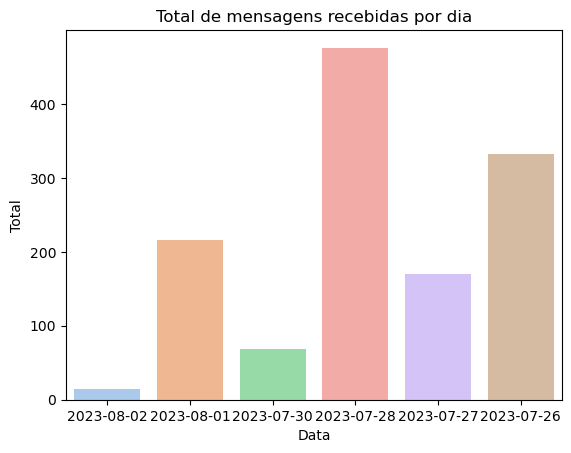

In [3]:
messages_per_day = "/kaggle/input/telegramchatanalytics/1 - Quantidade de mensangens recebidas por dia.csv"

# Carregar o arquivo CSV em um DataFrame do pandas
df_messages_per_day = pd.read_csv(messages_per_day)

grafico = sns.barplot(data=df_messages_per_day, x='context_date', y='message_amount', palette='pastel')
grafico.set(title='Total de mensagens recebidas por dia', xlabel='Data', ylabel='Total');
sns.set(rc = {'figure.figsize':(10,6)})

**Insights:** Em 28 de julho de 2023, o chatbot registrou um pico notável de interatividade, recebendo o maior volume de mensagens em um único dia.
Esse marco pode indicar a relevância crescente da tecnologia como canal de comunicação e assistência aos usuários, além de revelar a importância de investir em melhorias contínuas para otimizar a experiência do usuário.

## **Contagem do serviço mais utilizado no chatbot:**

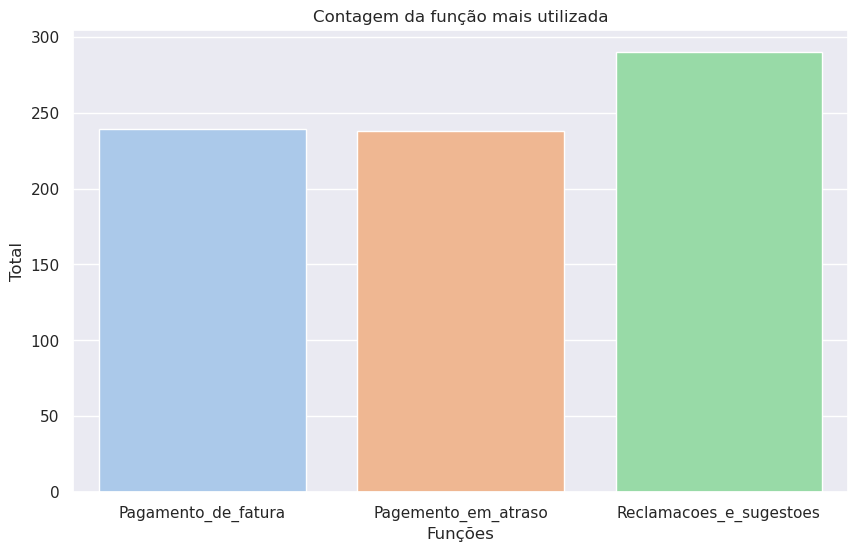

In [4]:
#Importar arquivo
count_by_options = "/kaggle/input/telegramchatanalytics/2- Quantidade de vezes que uma opo foi selecionada.csv"

# Carregar o arquivo CSV em um DataFrame do pandas
df_count_by_options = pd.read_csv(count_by_options)

# Exibir as primeiras linhas do DataFrame para verificar se a importação foi bem-sucedida
df_count_by_options.head()

grafico = sns.barplot(data=df_count_by_options, palette='pastel')
grafico.set(title='Contagem da função mais utilizada', xlabel='Funções', ylabel='Total');
sns.set(rc = {'figure.figsize':(10,7)})

**Insights:** Com base nos dados do gráfico, a opção mais selecionada pelos usuários foi relacionada a sugestões e reclamações. Esse padrão sugere que o chatbot está sendo utilizado como uma plataforma importante para o feedback dos clientes, fornecendo às empresas uma oportunidade valiosa de coletar insights sobre suas necessidades e sentimentos em relação aos produtos e serviços oferecidos.

## **Total de mensagens enviadas por cada usuário, por dia:**

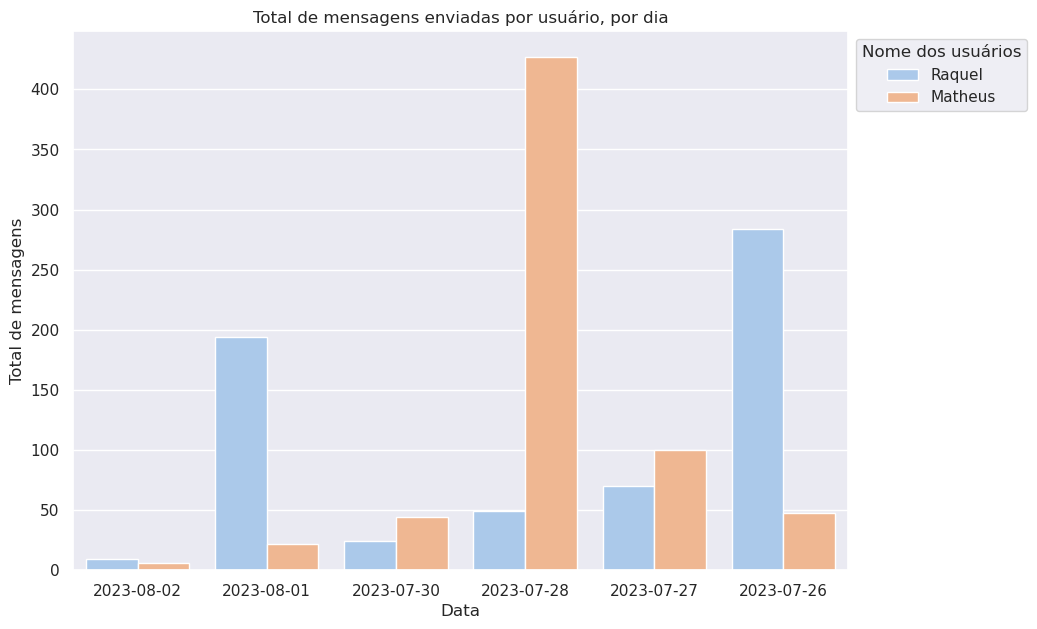

In [5]:
#Importação
number_of_messages_per_day = "/kaggle/input/telegramchatanalytics/3- Quantidade de mensagens que cada usuario envia por dia.csv"

# Carregar o arquivo CSV em um DataFrame do pandas
df_number_of_messages_per_day= pd.read_csv(number_of_messages_per_day)

#Gerando o gráfico
grafico = sns.barplot(data=df_number_of_messages_per_day, x='context_date', y='message_amount', hue='user_first_name', palette='pastel')
grafico.set(title='Total de mensagens enviadas por usuário, por dia', xlabel='Data', ylabel='Total de mensagens');
sns.set(rc = {'figure.figsize':(10,6)})
plt.legend(title='Nome dos usuários', loc='upper left', bbox_to_anchor=(1, 1))

**Insight**: Ao analisar a quantidade de usuários que acionam o chatbot ao longo de vários dias e a quantidade de mensagens que eles enviam, podemos identificar padrões de engajamento e detetar se determinados usuários estão enviando múltiplas mensagens durante um período prolongado. Essa observação pode sugerir que o chatbot precisa ser reavaliado para assegurar que as dúvidas ou problemas dessas pessoas estejam sendo resolvidos adequadamente. Uma abordagem mais aprofundada nesse aspecto pode levar a melhorias na experiência do usuário, refinando as respostas do chatbot e garantindo uma satisfação mais completa dos usuários/clientes com o serviço oferecido.

## **Média do tamanho das mensagens que os usuários enviam por dia:**

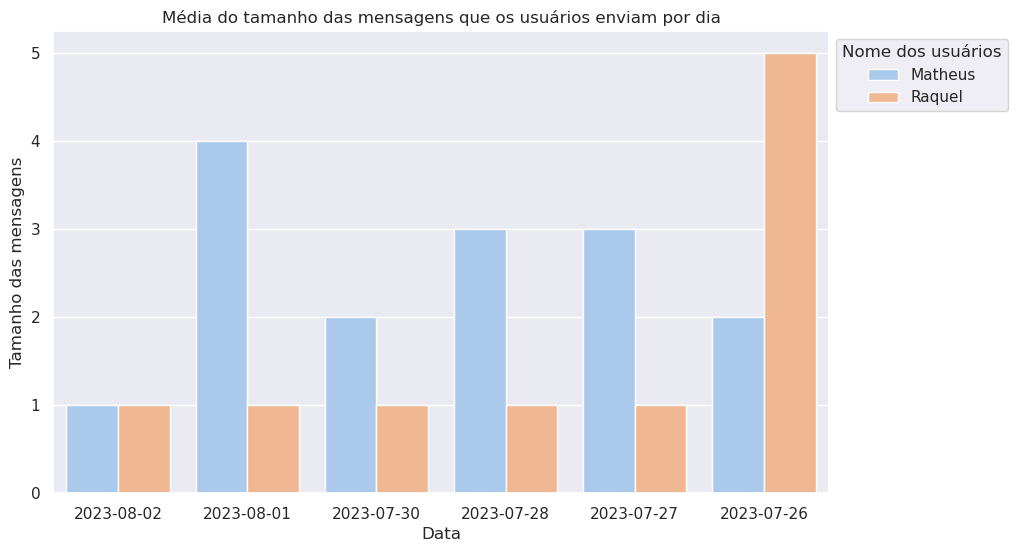

In [6]:
#Importação
average_of_messages_per_user = "/kaggle/input/telegramchatanalytics/4- Media do tamanho de mensagens que cada usuario manda por dia.csv"

# Carregar o arquivo CSV em um DataFrame do pandas
df_average_of_messages_per_user= pd.read_csv(average_of_messages_per_user)

#Gerando o gráfico
grafico = sns.barplot(data=df_average_of_messages_per_user, x='context_date', y='average_message_length', hue='user_first_name', palette='pastel')
grafico.set(title='Média do tamanho das mensagens que os usuários enviam por dia', xlabel='Data', ylabel='Tamanho das mensagens');
sns.set(rc = {'figure.figsize':(10,6)})
plt.legend(title='Nome dos usuários', loc='upper left', bbox_to_anchor=(1, 1))

**Insight:** Ao analisar o tamanho das mensagens enviadas pelos usuários ao chatbot, podemos obter insights cruciais sobre sua capacidade de compreender corretamente palavras-chave e intenções. Um aumento no tamanho médio das mensagens pode indicar uma necessidade de aprimorar o entendimento do chatbot para responder de forma mais completa e satisfatória às consultas. Além disso, essa análise oferece uma visão sobre o alinhamento do chatbot com as expectativas programadas, possibilitando a identificação de pontos de melhoria na interação e assegurando uma experiência mais eficaz e satisfatória para os usuários e clientes.

## **Média de mensagens recebidas por hora:**

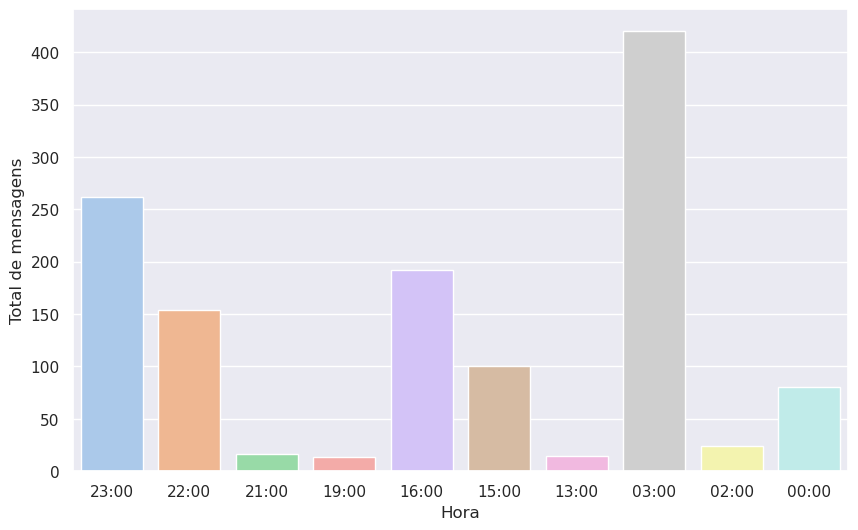

In [7]:
#Importação
number_of_messages_per_hour = "/kaggle/input/telegramchatanalytics/5- Media de mensagens por hora.csv"

# Carregar o arquivo CSV em um DataFrame do pandas
df_number_of_messages_per_hour= pd.read_csv(number_of_messages_per_hour)

#Gerando o gráfico
grafico = sns.barplot(data=df_number_of_messages_per_hour, x='rounded_hour', y='total_messages', palette='pastel')
grafico.set( xlabel='Hora', ylabel='Total de mensagens');
sns.set(rc = {'figure.figsize':(10,6)})

**Insight**:O horário de maior recebimento de mensagens pelo chatbot é às 3 da manhã. Esse padrão pode revelar um potencial público global, abrangendo diferentes fusos horários, ou até mesmo uma necessidade específica de atendimento e suporte durante esse período. 

# 4. Conclusão

A utilização de chatbots em conjunto com a análise de dados através de um pipeline é uma poderosa ferramenta que traz muitos benefícios às empresas. Os chatbots oferecem atendimento personalizado 24/7, enquanto a análise de dados revela padrões de comportamento e necessidades dos clientes. Essa combinação possibilita tomar decisões estratégicas, responder rapidamente a problemas e estreitar o relacionamento com os clientes, resultando em maior eficiência e satisfação.